https://realpython.com/generative-adversarial-networks/

In [1]:
!source gan_venv/bin/activate

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(111)

In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device is",device)

Device is cpu


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [6]:
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

In [7]:
len(train_set)

60000

In [8]:
# subset of the data - smaller for my CPU 
subset_indices = torch.arange(9600) # must be divisable by batch size 32
train_set      = Subset(train_set, subset_indices)

In [9]:
len(train_set)

9600

In [10]:
batch_size = 32
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True # Drops last batch if smaller than batch_size
)

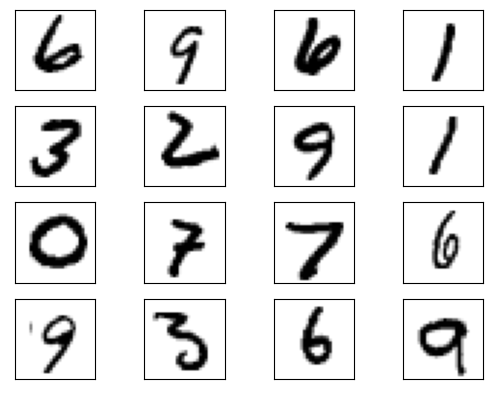

In [11]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Discriminator  
Vectorise the matrix

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [13]:
discriminator = Discriminator().to(device=device)

## Generator

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),    # 100-dimension input
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),   # 748-dimension output - to be organised into 28 x 28
            nn.Tanh(),              # output between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [15]:
generator = Generator().to(device=device) 

## Training the models

In [16]:
lr            = 1e-4#0.001 #0.0001
num_epochs    = 50
loss_function = nn.BCELoss() # binary cross-entropy; binary classification; synethetic or real

In [17]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator     = torch.optim.Adam(generator.parameters(),     lr=lr)

In [18]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples         = real_samples.to(device=device)
        real_samples_labels  = torch.ones((batch_size, 1)).to(device=device)      # 1 for real training data

        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)   # intial random data to generate from
        generated_samples    = generator(latent_space_samples)                    # generate samples

        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device) # 0 for synthetic generated samples

        all_samples        = torch.cat((real_samples,        generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator                 = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5733442306518555
Epoch: 0 Loss G.: 0.4730311930179596
Epoch: 1 Loss D.: 0.122592031955719
Epoch: 1 Loss G.: 4.4868998527526855
Epoch: 2 Loss D.: 0.06012553721666336
Epoch: 2 Loss G.: 3.3396620750427246
Epoch: 3 Loss D.: 0.04535776749253273
Epoch: 3 Loss G.: 4.055885314941406
Epoch: 4 Loss D.: 0.04273247718811035
Epoch: 4 Loss G.: 3.7388205528259277
Epoch: 5 Loss D.: 0.011137701570987701
Epoch: 5 Loss G.: 5.33212947845459
Epoch: 6 Loss D.: 0.05635199695825577
Epoch: 6 Loss G.: 5.044773101806641
Epoch: 7 Loss D.: 0.012480220757424831
Epoch: 7 Loss G.: 5.683660507202148
Epoch: 8 Loss D.: 0.0238199420273304
Epoch: 8 Loss G.: 4.532037734985352
Epoch: 9 Loss D.: 0.022757990285754204
Epoch: 9 Loss G.: 6.140458106994629
Epoch: 10 Loss D.: 0.24824607372283936
Epoch: 10 Loss G.: 6.464263916015625
Epoch: 11 Loss D.: 0.04038850590586662
Epoch: 11 Loss G.: 7.020928859710693
Epoch: 12 Loss D.: 0.12591469287872314
Epoch: 12 Loss G.: 7.496960639953613
Epoch: 13 Loss D.: 0.000632176

## Use the trained generator

In [19]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples    = generator(latent_space_samples)

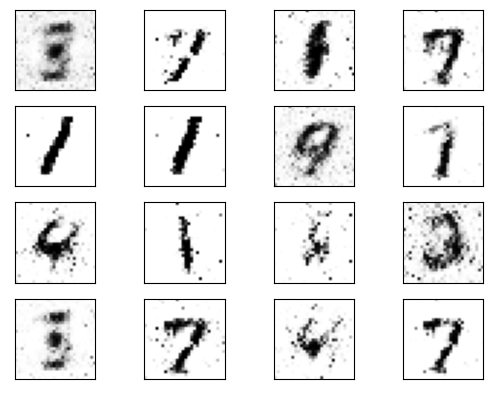

In [20]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])